In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman, catwoman
from multiprocessing import Pool
import emcee

In [31]:
# create a planet
t0 = 0. # [day]
per = 4.0552941 # [day]
a = 11.55 # [stellar radii]
inc = 90.#87.32 # [degrees]
phi = 90.
ecc = 0.
w = 90.
r = 0.1457 # [stellar radii]
Rs = 0.92868 # [Rsun]
Rp = r*Rs # [Rsun]
Mp_jup = 0.281 # [jupiter masses]
Teq = 1166.0 # [K]
T14 = 2.8032 # duration [hours]
b = 0.5#0.447

# calculate things in physical units
AU_to_meter = 1.496e11
day_to_second = 24.*60.*60.
Rsun_to_meter = 6.957e8
Rjup_to_meter = 7.149e7
Mjup_to_kg = 1.899e27
a_meter = a * Rs * Rsun_to_meter
per_seconds = per*day_to_second
Rs_meter = Rs * Rsun_to_meter
Rp_meter = r * Rs_meter
Mp_kg = Mp_jup * Mjup_to_kg

# calculate other things
v_orb = (2.*np.pi*a_meter) / (per_seconds) # [m/s]
#H = calc_H(Teq, Mp_kg, Rp_meter, mm=2.3) # [m]

# time axis based on simulated obs. info from or based on pandexo
# t_int = 79.5 # [s] per integration
# obs_window_size = (1.0*T14) / 24. # half-duration of whole observation in [day]
# t = np.arange(-obs_window_size, obs_window_size, (t_int / 60./60./24.))

# high res. time axis
t_int = 0.5 # [s] per integration
obs_window_size = (0.75*T14) / 24. # half-duration of whole observation in [day]
t = np.arange(-obs_window_size, obs_window_size, (t_int / 60./60./24.))

In [32]:
aparams  = catwoman.TransitParams()
aparams.t0 = t0                          #time of inferior conjuction (in days)
aparams.per = per                         #orbital period (in days)
aparams.rp = r                        #top semi-circle radius (in units of stellar radii)
aparams.rp2 = r                        #bottom semi-circle radius (in units of stellar radii)
aparams.a = a                         #semi-major axis (in units of stellar radii)
aparams.inc = inc                        #orbital inclination (in degrees)
aparams.ecc = ecc                        #eccentricity
aparams.w = w                         #longitude of periastron (in degrees)

aparams.limb_dark = "uniform"          #limbs darkening model

# aparams.limb_dark = "quadratic"
# aparams.u = [0.1, 0.3]


aparams.phi = phi                         #angle of rotation of top semi-circle (in degrees)
asymmodel = catwoman.TransitModel(aparams,t)         #initalises model
#asymLC = asymmodel.light_curve(params)                #calculates light curve


uparams  = batman.TransitParams()
uparams.t0 = t0                          #time of inferior conjuction (in days)
uparams.per = per                         #orbital period (in days)
uparams.rp = r                        #top semi-circle radius (in units of stellar radii)
uparams.a = a                         #semi-major axis (in units of stellar radii)
uparams.inc = inc                        #orbital inclination (in degrees)
uparams.ecc = ecc                        #eccentricity
uparams.w = w                         #longitude of periastron (in degrees)

uparams.u = []                   #limb darkening coefficients [u1, u2]
uparams.limb_dark = "uniform"          #limbs darkening model

# uparams.limb_dark = "quadratic"
# uparams.u = [0.1, 0.3]

unifmodel = batman.TransitModel(uparams,t)         #initalises model
#unifLC = unifmodel.light_curve(bparams)                #calculates light curve

Leading limb is of $R_{p,2}$, and trailing limb is of $R_{p,1} = R_{p,2} - \Delta R$.

In the uniform limb case ($R_{p,1} = R_{p,2,original}$), should have
$$
T_{14} = \frac{2 \left( R_\star + R_{p,2} \right) }{v_p},
$$
and
$$
T_{12} = T_{34} = \frac{2 R_{p,2} }{v_p}.
$$

In [36]:
def analytic_T14_uniform(Rs, Rp, vp):
    dx = 2.*(Rs + Rp)
    dt = dx / vp
    return dt

def analytic_T14_literature(P, aRs, rprs, b, i):
    #
    num = np.sqrt((1. + rprs)**2 - (b**2))
    den = aRs * np.sin(i*(np.pi/180.))
    Ttot = P*np.arcsin((num/den))/np.pi
    return Ttot

def analytic_T12_uniform(Rp, vp):
    dx = 2.*Rp
    dt = dx / vp
    return dt

def analytic_T34_uniform(Rp,vp):
    dt = analytic_T12_uniform(Rp,vp)
    return dt

In [37]:
## functions to measure the points of transit contact
## ASSUMING UNIFORM LD LAW
def get_T1_index(time, y):
    # get the index where T1 occurs
    # defined as where model flux first goes < 1
    pretransit_idxs = np.where((y == 1.0) & (time < np.median(time)))[0] # 'oot' indexes
    T1_idx = pretransit_idxs[-1] 
    return T1_idx
def get_T4_index(time, y):
    # get the index where T4 occurs
    # defined as where model flux last goes = 1
    posttransit_idxs = np.where((y == 1.0) & (time > np.median(time)))[0] # 'oot' indexes
    T4_idx = posttransit_idxs[0] 
    return T4_idx
def get_T2_index(time, y, asymmetric='no'):
    # get index where T2 occurs 
    fulldepth = np.min(y) # full-depth is the minimum model flux
    if asymmetric == 'no':
        # -- works best for uniform limb LC
        # we assume uniform LD, so depth is same during entire full transit
        # then, T2 is point where depth switches from > full-depth to = full-depth
        fulltransit_idxs = np.where(y == fulldepth)[0]
        T2_idx = fulltransit_idxs[0] - 1
        return T2_idx
    elif asymmetric == 'yes':
        # -- works for asymmetry up to at least 20%
        ft_idx = np.array([])
        ref = float('%.4f'%(fulldepth))
        for i, yval in enumerate(y):
            cy = float('%.4f'%(yval))
            if cy == ref:
                ft_idx = np.append(ft_idx, i)
        T2_idx = int(ft_idx[0])
        return T2_idx

def get_T3_index(time, y, asymmetric='no'):
    # get index where T3 occurs 
    fulldepth = np.min(y) # full-depth is the minimum model flux
    if asymmetric == 'no':
        # -- works best for uniform limb LC
        # we assume uniform LD, so depth is same during entire full transit
        # then, T3 is point where depth switches from = full-depth to > full-depth
        fulltransit_idxs = np.where(y == fulldepth)[0]
        T3_idx = fulltransit_idxs[-1] 
        return T3_idx
    elif asymmetric == 'yes':
        # -- works for asymmetry up to at least 20%
        ft_idx = np.array([])
        ref = float('%.4f'%(fulldepth))
        for i, yval in enumerate(y):
            cy = float('%.4f'%(yval))
            if cy == ref:
                ft_idx = np.append(ft_idx, i)
        T3_idx = int(ft_idx[-1])
        return T3_idx

Model values --
T14 = 184.70 min
T12 = 23.54 min
T34 = 23.54 min
Analytic predictions --
T14 = 184.38 min
T12 = 23.45 min
T34 = 23.45 min
Model value / Analytic value ---
T14 ratio = 1.002
T12 ratio = 1.004
T34 ratio = 1.004


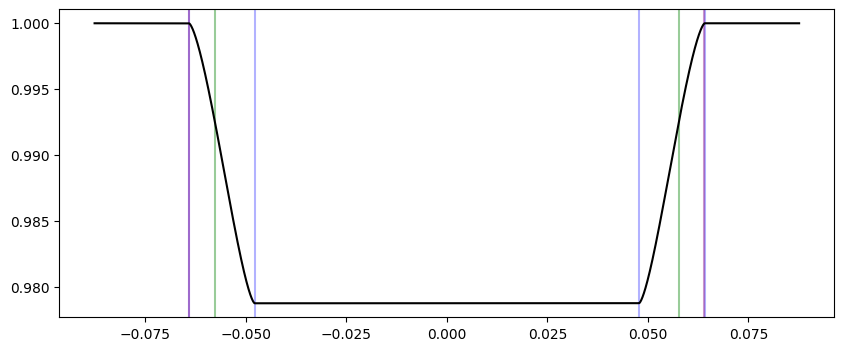

In [38]:
## Comparing this to a batman model ----
comp_lc = unifmodel.light_curve(uparams)

# get model contact points
T1guess = t[get_T1_index(t, comp_lc)]
T2guess = t[get_T2_index(t, comp_lc, asymmetric='no')]
T3guess = t[get_T3_index(t, comp_lc, asymmetric='no')]
T4guess = t[get_T4_index(t, comp_lc)]
# compute model-derived durations
T14_model = T4guess - T1guess
T12_model = T2guess - T1guess
T34_model = T4guess - T3guess

print('Model values --')
print('T14 = %.2f min'%(T14_model*24.*60.))
print('T12 = %.2f min'%(T12_model*24.*60.))
print('T34 = %.2f min'%(T34_model*24.*60.))

# compute corresponding analytic-formula-derived values in [s]
T14_analy = analytic_T14_uniform(Rs_meter, Rp_meter, v_orb)
T12_analy = analytic_T12_uniform(Rp_meter, v_orb)
T34_analy = analytic_T34_uniform(Rp_meter, v_orb)
# convert to [day] like model values
T14_analy /= (60.*60.*24.)
T12_analy /= (60.*60.*24.)
T34_analy /= (60.*60.*24.)

T14_lit = analytic_T14_literature(per, a, r, b, inc) # [day]

print('Analytic predictions --')
print('T14 = %.2f min'%(T14_analy*24.*60.))
print('T12 = %.2f min'%(T12_analy*24.*60.))
print('T34 = %.2f min'%(T34_analy*24.*60.))

# compare
T14_ratio = T14_model / T14_analy
T12_ratio = T12_model / T12_analy
T34_ratio = T34_model / T34_analy

print('Model value / Analytic value ---')
print('T14 ratio = %.3f'%(T14_ratio))
print('T12 ratio = %.3f'%(T12_ratio))
print('T34 ratio = %.3f'%(T34_ratio))

fig, ax = plt.subplots(figsize=(10,4))
ax.axvline(T1guess, c='blue', alpha=0.3)
ax.axvline(T2guess, c='blue', alpha=0.3)
ax.axvline(T3guess, c='blue', alpha=0.3)
ax.axvline(T4guess, c='blue', alpha=0.3)
ax.axvline(0.5*T14_analy, c='purple', alpha=0.4)
ax.axvline(-0.5*T14_analy, c='purple', alpha=0.4)
ax.axvline(0.5*T14_lit, c='green', alpha=0.4)
ax.axvline(-0.5*T14_lit, c='green', alpha=0.4)
ax.plot(t, comp_lc, c='black')
plt.show()